In [45]:
# Przygotowanie środowiska
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [50]:
# Globalne zmienne
r = 0.025
inflacja = 0.025
belka = 0.19
podatek_od_prywatyzacji = 0.15
waloryzacja_emerytur = inflacja + 0.0075

# Zmienna dla konkretnego przypadku
prognozowana_emerytura = 2200
efektywny_pit = (prognozowana_emerytura*12 - 12*556 - 3091) * 0.17 / (prognozowana_emerytura*12)
ofe = 29000
do_emerytury = 6
lat_na_emeryturze = 24

Text(0.5, 1.0, 'Stopy waloryzacji kapitału zgromadzonego w ZUS')

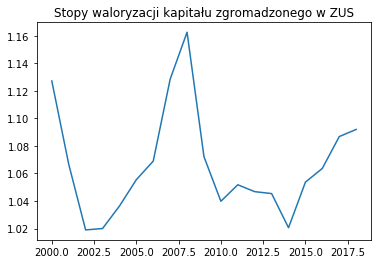

In [51]:
# Historyczne wartości waloryzacji kapitału zgromadzonego w ZUS
hist_waloryzacja = [1.1272, 1.0668, 1.0190, 1.0200, 1.0363, 1.0555, 1.0690, 1.1285, 1.1626, 1.0722, 1.0398, 1.0518, 1.0468, 1.0454, 1.0206, 1.0537, 1.0637, 1.0868, 1.0920]
mean_hist_waloryzacja = np.mean(hist_waloryzacja)
q40_hist_waloryzacja = np.quantile(hist_waloryzacja, 0.4)

plt.plot([int(x) for x in range(2000, 2019)], hist_waloryzacja)
plt.title('Stopy waloryzacji kapitału zgromadzonego w ZUS')

In [52]:
# Wariant 1: Prywatyzacja środków
# Etap 1: Do emerytury

# w 1. roku sprywatyzowania OFE wartość kapitału topnieje o 7.5%, reszta pracuje na inwestycji w ramach IKE bez podatku belki
# w 2. roku wartość kapitału topnieje o kolejne 7.5%, ale pracuje na inwestycji w ramach IKE bez podatku Belki
# w 3. i każdym kolejnym roku do emerytury wartość kapitału rośnie o oczekiwaną stopę zwrotu, bez podatku Belki
NPV_IKE = ofe * (1 - podatek_od_prywatyzacji/2) * (1+r) * (1 - podatek_od_prywatyzacji/2) * (1+r) * np.power((1+r), do_emerytury-2)

# W momencie wypłaty środków z IKE ich wartość nominalna jest wysoka, jednak wartość realna zjadana jest przez inflację, toteż wartość nominalna > realna. Deflator:
NPV_IKE = NPV_IKE / np.power((1+inflacja), do_emerytury)
print("Zgromadzony kapitał na IKE w momencie przejścia na emeryturę wynosi %d PLN na dzisiejsze pieniądze (po opodatkowaniu)" % NPV_IKE)

Zgromadzony kapitał na IKE w momencie przejścia na emeryturę wynosi 24813 PLN na dzisiejsze pieniądze (po opodatkowaniu)


In [53]:
# Etap 2: Po emeryturze
projekcja_IKE = pd.Series(range(1, lat_na_emeryturze + 1), name='rok_emerytury').to_frame()

NPV_IKE_dyn = NPV_IKE
NPV_IKE_list = list()
kapital_rok = list()

# Zakładamy, że na emeryturze kapitał pracuje nam na bezpiecznej lokacie (opodatkowanej podatkiem Belki)
for rok in range(lat_na_emeryturze):
    # Kapitał wypłacamy sobie proporcjonalnie do pozostałych lat na emeryturze - np. pozostało nam (statystycznie) 5 lat, więc wypłacamy sobie 1/5 tego co zostało
    kapital_rok.append(NPV_IKE_dyn / (lat_na_emeryturze - rok))
    # w międzyczasie, kapitał, który pozostał inwestujemy, ale zżera go nam też inflacja
    NPV_IKE_dyn = (NPV_IKE_dyn - NPV_IKE_dyn/(lat_na_emeryturze - rok)) * (1 + r*(1-belka)) / (1+inflacja)
    NPV_IKE_list.append(NPV_IKE_dyn)
    
projekcja_IKE['NPV_IKE'] = NPV_IKE_list
projekcja_IKE['kapital_rok'] = kapital_rok
projekcja_IKE['IKE_dodatek_emerytura'] = round(projekcja_IKE['kapital_rok']/12, 2)

print("Efekt wybrania prywatyzacji:")
print("W pierwszym roku emerytury zwiększy nam emeryturę o {} PLN".format(projekcja_IKE['IKE_dodatek_emerytura'].iloc[0]))
print("W {}. roku emerytury zwiększy nam emeryturę o {} PLN".format(projekcja_IKE.shape[0], projekcja_IKE['IKE_dodatek_emerytura'].iloc[projekcja_IKE.shape[0]-1]))
print("\n")
print("Jeśli umrzemy wcześniej niż średnia, wtedy niewykorzystany kapitał jest dziedziczony")
print("Jeśli przeżyjemy dłużej niż średnia, po wyczerpaniu środków z IKE emerytura wraca do bazowej wielkości")
print("\n")
print("Szanse: wyższy zwrot z inwestycji, niższa inflacja, zmiana zasad pobierania podatku Belki na bardziej korzystne dla konsumentów")
print("Zagrożenia: Ponowna grabież środków tym razem z IKE, kiepskie inwestycje, wysoka inflacja, podwyżka podatku Belki")
projekcja_IKE

Efekt wybrania prywatyzacji:
W pierwszym roku emerytury zwiększy nam emeryturę o 86.16 PLN
W 24. roku emerytury zwiększy nam emeryturę o 77.43 PLN


Jeśli umrzemy wcześniej niż średnia, wtedy niewykorzystany kapitał jest dziedziczony
Jeśli przeżyjemy dłużej niż średnia, po wyczerpaniu środków z IKE emerytura wraca do bazowej wielkości


Szanse: wyższy zwrot z inwestycji, niższa inflacja, zmiana zasad pobierania podatku Belki na bardziej korzystne dla konsumentów
Zagrożenia: Ponowna grabież środków tym razem z IKE, kiepskie inwestycje, wysoka inflacja, podwyżka podatku Belki


,rok_emerytury,NPV_IKE,kapital_rok,IKE_dodatek_emerytura
0,1,23669.048291,1033.880208,86.16
1,2,22535.042351,1029.089056,85.76
2,3,21411.038409,1024.320107,85.36
3,4,20296.968118,1019.573258,84.96
4,5,19192.763548,1014.848406,84.57
5,6,18098.357185,1010.145450,84.18
6,7,17013.681930,1005.464288,83.79
7,8,15938.671094,1000.804819,83.40
8,9,14873.258400,996.166943,83.01
9,10,13817.377974,991.550560,82.63


In [54]:
# Wariant 2: Przeniesienie środków do ZUS
# Etap 1: Do emerytury

# Środki z OFE zostają przekazane do ZUS, gdzie korzystają z corocznej waloryzacji kapitału, która historycznie była wysoka
# Zeszłoroczna waloryzacja była wyższa niż średnia
# Do obliczeń założymy konserwatywnie nie średnią, ani nie medianę (jeszcze niższa), tylko 40 percentyl tej wielkości od 2000 roku.
# Stopa waloryzacji jest pochodną rozwoju gospodarczego, założenie 40 percentyla to założenie o łagodnym, acz długotrwałym spowolnieniu gospodarczym.
# To jak najbardziej realne założenie, nieco gorsze od tego co wszyscy się spodziewamy. Na zapas.

# Środki z OFE zapisane są na konto w ZUS, są waloryzowane co roku, aż do momentu przejścia na emeryturę.
# Ich realna wartość będzie nieco zmniejszona przez inflację, co też jest uwzględnione
NPV_ZUS = ofe * np.power(q40_hist_waloryzacja, do_emerytury) / np.power((1+inflacja), do_emerytury)  #  * (1-efektywny_pit)

# Uwaga: od tego kapitału będzie trzeba zapłacić podatek
print("Zgromadzony kapitał na ZUS w momencie przejścia na emeryturę wynosi %d PLN na dzisiejsze pieniądze (przed opodatkowaniem)" % NPV_ZUS)

Zgromadzony kapitał na ZUS w momencie przejścia na emeryturę wynosi 33930 PLN na dzisiejsze pieniądze (przed opodatkowaniem)


In [55]:
# kontynuacja: co po emeryturze?
projekcja_ZUS = pd.Series(range(1, lat_na_emeryturze + 1), name='rok_emerytury').to_frame()

# Zakładamy, że na emeryturze kapitał już nie jest waloryzowany. Zamiast tego waloryzowana jest emerytura
# Waloryzacja emerytury historycznie była zauważalnie niższa niż waloryzacja kapitału, dlatego tutaj przyjmujemy znacznie mniejsze wartości
# Dobra wiadomość jest taka, że waloryzacja emerytury nie może być niższa niż stopa inflacji statystycznego gospodarstwa emerytów powiększona o chyba 20% wzrostu gospodarczego.

# Tutaj wracamy do wartości nominalnej, bo od niej liczy się podatek
NPV_ZUS_dyn = NPV_ZUS * np.power((1+inflacja), do_emerytury) 
NPV_ZUS_list = list()
kapital_rok = list()
for rok in range(lat_na_emeryturze):
    # Emerytura jest obliczona w taki sposób, że ZUS wypłaca nam nasz kapitał proporcjonalnie do pozostałych lat na emeryturze
    # tutaj używamy wartości nominalnych, by móc poprawnie wyliczyć efektywny PIT) A POTEM ponownie stosujemy deflator sprzed emerytury
    kapital_rok.append(NPV_ZUS_dyn / (lat_na_emeryturze - rok) * (1-efektywny_pit) / np.power((1+inflacja), do_emerytury))
    # w międzyczasie, kapitał, który pozostał inwestujemy, ale zżera go nam też inflacja
    NPV_ZUS_dyn = (NPV_ZUS_dyn - NPV_ZUS_dyn/(lat_na_emeryturze - rok)) * (1+waloryzacja_emerytur) / (1+inflacja)
    NPV_ZUS_list.append(NPV_ZUS_dyn)
    
projekcja_ZUS['NPV_ZUS'] = NPV_ZUS_list
projekcja_ZUS['kapital_rok'] = kapital_rok
projekcja_ZUS['ZUS_dodatek_emerytura'] = round(projekcja_ZUS['kapital_rok']/12, 2)

print("Efekt wybrania ZUSu:")
print("W pierwszym roku emerytury zwiększy nam emeryturę o {} PLN".format(projekcja_ZUS['ZUS_dodatek_emerytura'].iloc[0]))
print("W {}. roku emerytury zwiększy nam emeryturę o {} PLN".format(projekcja_ZUS.shape[0], projekcja_ZUS['ZUS_dodatek_emerytura'].iloc[projekcja_ZUS.shape[0]-1]))
print("\n")
print("Jeśli umrzemy wcześniej, wtedy niewykorzystany kapitał nie jest dziedziczony")
print("Jeśli przeżyjemy dłużej, po wyczerpaniu środków emerytura dalej jest waloryzowana o stopę nieco wyższą niż inflacja")
print("\n")
print("Szanse: podwyższenie kwoty wolnej od podatku, obniżenie PIT, przeciętny lub dobry rozwój gospodarki Polski")
print("Zagrożenia: Ustawowe obniżenie emerytur, zawieszenie lub zmiana zasad waloryzacji kapitału, problemy z ZUS")

projekcja_ZUS

Efekt wybrania ZUSu:
W pierwszym roku emerytury zwiększy nam emeryturę o 105.19 PLN
W 24. roku emerytury zwiększy nam emeryturę o 124.4 PLN


Jeśli umrzemy wcześniej, wtedy niewykorzystany kapitał nie jest dziedziczony
Jeśli przeżyjemy dłużej, po wyczerpaniu środków emerytura dalej jest waloryzowana o stopę nieco wyższą niż inflacja


Szanse: podwyższenie kwoty wolnej od podatku, obniżenie PIT, przeciętny lub dobry rozwój gospodarki Polski
Zagrożenia: Ustawowe obniżenie emerytur, zawieszenie lub zmiana zasad waloryzacji kapitału, problemy z ZUS


,rok_emerytury,NPV_ZUS,kapital_rok,ZUS_dodatek_emerytura
0,1,37985.779381,1262.324411,105.19
1,2,36600.083930,1271.560931,105.96
2,3,35192.076266,1280.865036,106.74
3,4,33761.504060,1290.237219,107.52
4,5,32308.112483,1299.677979,108.31
5,6,30831.644185,1309.187818,109.10
6,7,29331.839271,1318.767241,109.90
7,8,27808.435280,1328.416757,110.70
8,9,26261.167159,1338.136880,111.51
9,10,24689.767238,1347.928125,112.33


(0, 126.7485)

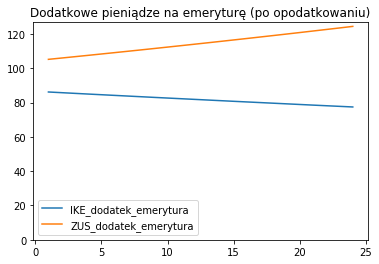

In [56]:
# Porównanie OFE->IKE vs. OFE->ZUS
plt.plot(projekcja_IKE['rok_emerytury'], projekcja_IKE['IKE_dodatek_emerytura'])
plt.plot(projekcja_IKE['rok_emerytury'], projekcja_ZUS['ZUS_dodatek_emerytura'])
plt.title('Dodatkowe pieniądze na emeryturę (po opodatkowaniu)')
plt.legend()
plt.ylim(0)

In [57]:
# Podsumowanie
suma_dodatku_od_IKE = sum(projekcja_IKE['IKE_dodatek_emerytura'])*12
suma_dodatku_od_ZUS = sum(projekcja_ZUS['ZUS_dodatek_emerytura'])*12

stosunek_ZUS_do_IKE = round((suma_dodatku_od_ZUS/suma_dodatku_od_IKE - 1)*100, 1)

if suma_dodatku_od_ZUS > suma_dodatku_od_IKE:
    print("Wybranie ZUS zaowocuje średnio o {}% wyższym dodatkiem do emerytury".format(stosunek_ZUS_do_IKE))
elif suma_dodatku_od_ZUS < suma_dodatku_od_IKE:
    print("Wybranie ZUS zaowocuje średnioo {}% niższym dodatkiem do emerytury".format(stosunek_ZUS_do_IKE))
else:
    print("ganz egal")

Wybranie ZUS zaowocuje średnio o 40.2% wyższym dodatkiem do emerytury
